In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sksurv.preprocessing import OneHotEncoder

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

import matplotlib.pyplot as plt
import random

In [81]:
from sksurv.datasets import load_veterans_lung_cancer

va_x, va_y = load_veterans_lung_cancer()

random.seed(43)

for i in va_y:
    if random.randint(0,10) < 9:
        i[0] = False

va_x_train, va_x_test, va_y_train, va_y_test = train_test_split(
    va_x, va_y, test_size=0.2, stratify=va_y["Status"], random_state=0
)

min_idx = np.argmin(va_y_train['Survival_in_days'])
max_idx = np.argmax(va_y_train['Survival_in_days'])

va_y_train[min_idx]['Status'] = 0
va_y_train[max_idx]['Status'] = 0

va_y_train

array([( True,  20.), (False, 357.), (False,  18.), (False,  52.),
       (False, 340.), (False, 122.), ( True, 162.), (False, 123.),
       (False,  16.), (False, 182.), (False,   8.), (False, 117.),
       ( True,  53.), (False, 162.), (False,  31.), (False, 100.),
       (False,   7.), (False,  59.), (False, 143.), (False,   2.),
       ( True, 132.), (False,  51.), (False, 118.), (False,  56.),
       (False,  95.), (False,  43.), ( True,  54.), (False, 133.),
       (False,  97.), ( True, 384.), ( True, 111.), ( True, 177.),
       (False,  48.), (False,  19.), (False, 139.), (False, 587.),
       (False, 260.), (False, 103.), (False, 153.), ( True, 283.),
       (False, 117.), (False,  25.), (False, 231.), (False,  25.),
       (False,  36.), ( True,  84.), (False,  24.), ( True,  52.),
       (False, 392.), (False,  83.), (False,  13.), (False, 250.),
       (False,  27.), (False, 100.), ( True,  87.), (False,  52.),
       (False,  29.), (False,  49.), (False,  63.), ( True,  2

In [172]:
va_y_train[0] = (True, 0.000001)
va_y_train[1] = (True, 17.90999985)
va_y_train[2] = (True, 20000)
va_y_train

array([( True, 1.00000000e-06), ( True, 1.79099998e+01),
       ( True, 2.00000000e+04), (False, 5.20000000e+01),
       (False, 3.40000000e+02), (False, 1.22000000e+02),
       ( True, 1.62000000e+02), (False, 1.23000000e+02),
       (False, 1.60000000e+01), (False, 1.82000000e+02),
       (False, 8.00000000e+00), (False, 1.17000000e+02),
       ( True, 5.30000000e+01), (False, 1.62000000e+02),
       (False, 3.10000000e+01), (False, 1.00000000e+02),
       (False, 7.00000000e+00), (False, 5.90000000e+01),
       (False, 1.43000000e+02), (False, 2.00000000e+00),
       ( True, 1.32000000e+02), (False, 5.10000000e+01),
       (False, 1.18000000e+02), (False, 5.60000000e+01),
       (False, 9.50000000e+01), (False, 4.30000000e+01),
       ( True, 5.40000000e+01), (False, 1.33000000e+02),
       (False, 9.70000000e+01), ( True, 3.84000000e+02),
       ( True, 1.11000000e+02), ( True, 1.77000000e+02),
       (False, 4.80000000e+01), (False, 1.90000000e+01),
       (False, 1.39000000e+02),

In [173]:
encoder = OneHotEncoder()

# Fit and transform the data
va_x_train = encoder.fit_transform(va_x_train)

In [174]:
from sklearn.model_selection import KFold, GridSearchCV
from sksurv.metrics import cumulative_dynamic_auc, as_concordance_index_ipcw_scorer

estimated_alphas = np.arange(0.0001, 0.1 + 0.005, 0.0005)

cv = KFold(n_splits=3, shuffle = True, random_state = 40)
gcv = GridSearchCV(
    as_concordance_index_ipcw_scorer(CoxnetSurvivalAnalysis(l1_ratio=0.5, fit_baseline_model = True, max_iter = 50000, normalize = False)),
    param_grid = {"estimator__alphas": [[v] for v in estimated_alphas]},
    cv = cv,
    error_score = 0,
    n_jobs = -1,
).fit(va_x_train, va_y_train)

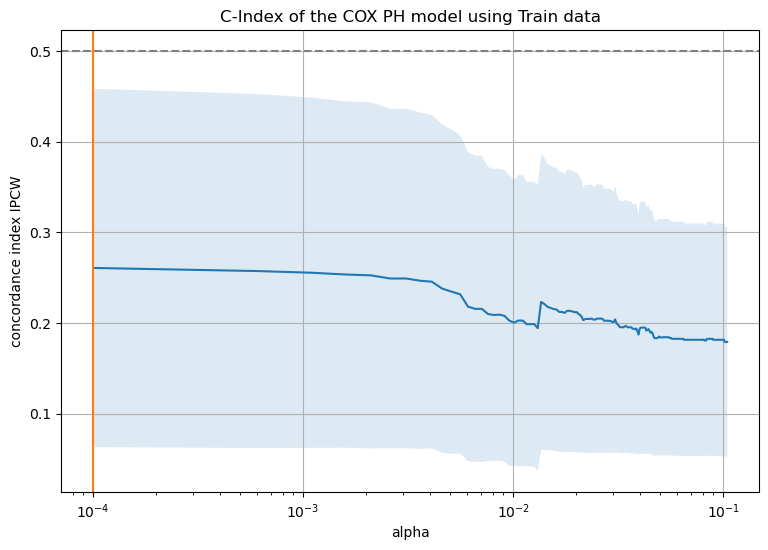

In [175]:
cv_results = pd.DataFrame(gcv.cv_results_)

alphas = cv_results.param_estimator__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

best_model = gcv.best_estimator_.estimator
best_alpha = gcv.best_params_["estimator__alphas"][0]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index IPCW")
ax.set_xlabel("alpha")
ax.axvline(best_alpha, c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)
plt.title("C-Index of the COX PH model using Train data")
plt.show()

C:\Users\inigo\anaconda3\envs\P10\Lib\site-packages\sksurv\metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


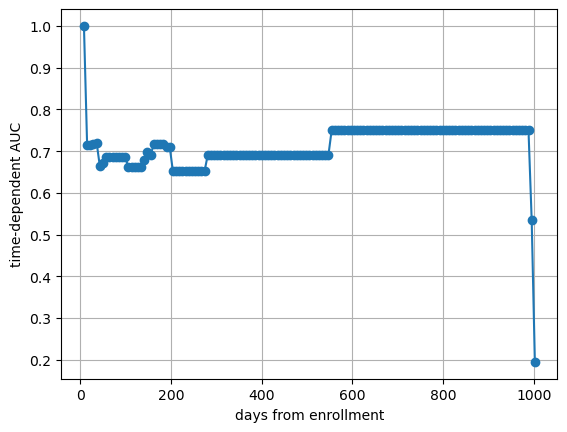

In [119]:
va_times = np.arange(1, max(va_y_test['Survival_in_days']), 7)
cph_risk_scores = cph.predict(va_x_test, alpha = 0.01)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(va_y_train, va_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

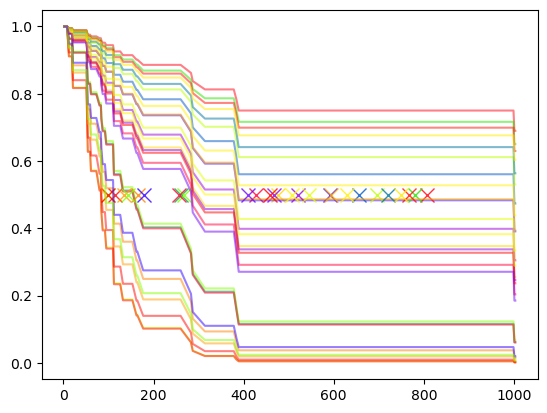

In [120]:
G = cph.predict_survival_function(va_x_test, alpha = None)
predicted_values = []
for g in G:
    color = plt.cm.prism(np.random.rand())  # Random color
    plt.plot(g.x, g.y, color=color, alpha=0.5)

    median_value = np.trapz(g.y, g.x)
    predicted_values += [median_value]
    plt.plot(median_value, 0.5, 'x', color=color, alpha=0.8, markersize=10)
plt.show()